In [1]:
import pandas as pd
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting, prim
from ema_workbench import (RealParameter, ScalarOutcome, Constant,
                           Model, MultiprocessingEvaluator, SequentialEvaluator, ema_logging,
                           perform_experiments, Policy, Scenario)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench.util.utilities import (save_results, load_results)
import seaborn as sns
import matplotlib.pyplot as plt

In [365]:
# load results from scenario discovery
experiment, result = load_results('ANALYSIS_results/01_model_run.tar.gz')

In [384]:
#data = pd.concat([experiment, pd.DataFrame(result)['Minimum water level full network']], 1)
data = experiment[['discount rate 0', 'discount rate 1', 'discount rate 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate', 'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail', 'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax', 'A.5_pfail', 'A.5_Brate']]
#data = data.drop(['model', 'scenario', 'policy'], 1)

In [385]:
data = data.apply(lambda x: pd.to_numeric(x, downcast="float"))
data

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,A.3_Bmax,A.3_pfail,A.3_Brate,A.4_Bmax,A.4_pfail,A.4_Brate,A.5_Bmax,A.5_pfail,A.5_Brate
0,2.5,1.5,2.5,28.0,215.830215,0.868790,1.5,251.388474,0.414318,10.0,43.436543,0.861445,1.0,248.306412,0.819843,1.5,140.727814,0.222125,1.0
1,1.5,3.5,3.5,100.0,280.830353,0.067549,1.0,282.517792,0.877360,1.5,215.394409,0.345914,1.0,73.761612,0.506127,1.0,79.934547,0.663898,1.0
2,1.5,1.5,3.5,112.0,207.368073,0.661928,1.5,292.273651,0.336442,1.5,183.134872,0.676212,1.5,203.237885,0.442524,1.0,164.903519,0.487958,1.0
3,1.5,2.5,2.5,114.0,279.845428,0.522214,10.0,155.039597,0.005102,1.5,145.505203,0.445787,1.0,135.982880,0.292759,10.0,298.976898,0.898434,10.0
4,1.5,3.5,2.5,99.0,321.197174,0.713621,1.0,42.722069,0.641709,10.0,253.765762,0.582081,10.0,163.504715,0.002436,1.5,145.643890,0.002812,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,3.5,2.5,4.5,56.0,147.315079,0.303754,1.5,178.256134,0.286489,1.5,194.218567,0.698183,1.0,183.166550,0.045337,10.0,248.277466,0.404624,1.5
49996,2.5,2.5,4.5,13.0,237.411072,0.707113,10.0,249.240952,0.863971,1.5,55.779270,0.830474,1.5,145.752686,0.678672,10.0,310.991821,0.538659,1.5
49997,4.5,1.5,1.5,67.0,209.666992,0.756792,10.0,223.374603,0.046814,10.0,159.305145,0.891612,1.5,225.289917,0.026207,10.0,337.536163,0.120807,1.0
49998,2.5,3.5,2.5,26.0,70.561531,0.095998,1.5,145.991180,0.024110,1.5,46.096867,0.489917,1.0,140.713715,0.839557,1.0,151.175629,0.376514,1.0


In [386]:
import statsmodels.api as sm
data = (data - data.min()) / (data.max() - data.min())
data = sm.add_constant(data)
mod = sm.OLS(pd.DataFrame(result)['Minimum water level full network'], data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Minimum water level full network   R-squared:                       0.030
Model:                                          OLS   Adj. R-squared:                  0.030
Method:                               Least Squares   F-statistic:                     81.90
Date:                              Thu, 10 Jun 2021   Prob (F-statistic):          4.39e-314
Time:                                      12:05:51   Log-Likelihood:                 13115.
No. Observations:                             50000   AIC:                        -2.619e+04
Df Residuals:                                 49980   BIC:                        -2.601e+04
Df Model:                                        19                                         
Covariance Type:                          nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       4.4027      0.005    826.472      0.000       4.392       4.413
discount rate 0             0.0032      0.002      1.377      0.169      -0.001       0.008
discount rate 1             0.0231      0.002     10.184      0.000       0.019       0.028
discount rate 2            -0.0197      0.002     -8.663      0.000      -0.024      -0.015
A.0_ID flood wave shape     0.0434      0.003     14.980      0.000       0.038       0.049
A.1_Bmax                    0.0253      0.003      8.686      0.000       0.020       0.031
A.1_pfail                  -0.0259      0.003     -8.771      0.000      -0.032      -0.020
A.1_Brate                   0.0221      0.002     11.997      0.000       0.019       0.026
A.2_Bmax                   -0.0281      0.003     -9.637      0.000      -0.034      -0.022
A.2_pfail                  -0.0373      0.003    -12.758      0.000      -0.043      -0.032
A.2_Brate                   0.0080      0.002      4.324      0.000       0.004       0.012
A.3_Bmax                    0.0193      0.003      6.512      0.000       0.013       0.025
A.3_pfail                  -0.0279      0.003     -9.498      0.000      -0.034      -0.022
A.3_Brate                  -0.0182      0.002     -9.995      0.000      -0.022      -0.015
A.4_Bmax                    0.0476      0.003     16.259      0.000       0.042       0.053
A.4_pfail                  -0.0088      0.003     -2.997      0.003      -0.015      -0.003
A.4_Brate                   0.0049      0.002      2.642      0.008       0.001       0.009
A.5_Bmax                    0.0068      0.003      2.338      0.019       0.001       0.013
A.5_pfail                  -0.0161      0.003     -5.480      0.000      -0.022      -0.010
A.5_Brate                   0.0097      0.002      5.329      0.000       0.006       0.013
==============================================================================
Omnibus:                    19347.247   Durbin-Watson:                   1.516
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            85977.581
Skew:                           1.876   Prob(JB):                         0.00
Kurtosis:                       8.214   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [354]:
# set up PRIM

# uncertainties
x_prim = experiment[['discount rate 0', 'discount rate 1', 'discount rate 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate', 'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail', 'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax', 'A.5_pfail', 'A.5_Brate']]

# outcomes of interest -> bad outcomes
#y_prim = (result['Expected Number of Deaths'] > 0.1) | (result['Minimum water level full network'] < 4.2)

y_prim = ((result['Minimum water level full network'] < 4.2) & (result['RfR Investment Costs'] > 1))

In [350]:
sum(y_prim)

3852

In [319]:
# run PRIM
prim_alg = prim.Prim(x_prim, y_prim, threshold=0.1)
box1 = prim_alg.find_box()

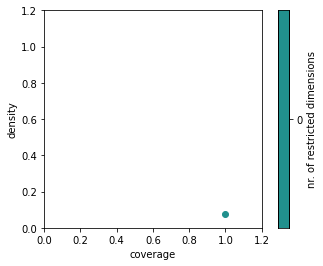

In [320]:
# show tradeoff
box1.show_tradeoff()
plt.show()

coverage    0.956801
density     0.756779
id                 1
mass            0.95
mean        0.756779
res_dim            1
Name: 1, dtype: object

              box 1                                          
                min         max                     qp values
A.4_Bmax  30.374939  334.007747  [-1.0, 0.003335705120762906]



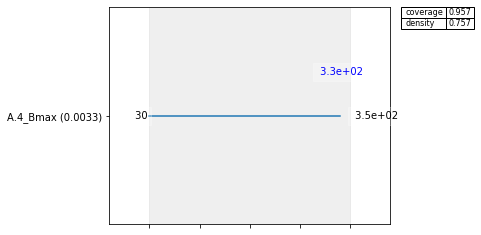

In [291]:
# inspect box
box_n = 1
box1.inspect(box_n)
box1.inspect(box_n, style='graph')
plt.show()

In [292]:
# select box with making trade-off
box1.select(box_n)

In [293]:
# get scenarios and outcomes with selected box
scenarios = x_prim.iloc[box1.yi]
outcome = {k:v[box1.yi] for k,v in result.items()}

In [294]:
scenarios = scenarios.drop_duplicates()
scenarios

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,A.3_Bmax,A.3_pfail,A.3_Brate,A.4_Bmax,A.4_pfail,A.4_Brate,A.5_Bmax,A.5_pfail,A.5_Brate
0,2.5,1.5,2.5,28.0,215.830212,0.868790,1.5,251.388475,0.414318,10.0,43.436542,0.861445,1.0,248.306411,0.819843,1.5,140.727808,0.222125,1.0
1,1.5,3.5,3.5,100.0,280.830345,0.067549,1.0,282.517802,0.877360,1.5,215.394402,0.345914,1.0,73.761613,0.506127,1.0,79.934548,0.663898,1.0
2,1.5,1.5,3.5,112.0,207.368075,0.661928,1.5,292.273645,0.336442,1.5,183.134877,0.676212,1.5,203.237883,0.442524,1.0,164.903520,0.487958,1.0
3,1.5,2.5,2.5,114.0,279.845435,0.522214,10.0,155.039589,0.005102,1.5,145.505205,0.445787,1.0,135.982874,0.292759,10.0,298.976905,0.898434,10.0
4,1.5,3.5,2.5,99.0,321.197178,0.713621,1.0,42.722067,0.641709,10.0,253.765756,0.582082,10.0,163.504714,0.002436,1.5,145.643896,0.002812,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3.5,2.5,4.5,56.0,147.315085,0.303754,1.5,178.256141,0.286489,1.5,194.218572,0.698183,1.0,183.166556,0.045337,10.0,248.277461,0.404624,1.5
496,2.5,2.5,4.5,13.0,237.411065,0.707113,10.0,249.240949,0.863971,1.5,55.779272,0.830474,1.5,145.752683,0.678672,10.0,310.991833,0.538659,1.5
497,4.5,1.5,1.5,67.0,209.666992,0.756792,10.0,223.374608,0.046814,10.0,159.305147,0.891612,1.5,225.289922,0.026207,10.0,337.536149,0.120807,1.0
498,2.5,3.5,2.5,26.0,70.561535,0.095998,1.5,145.991187,0.024110,1.5,46.096867,0.489917,1.0,140.713707,0.839557,1.0,151.175627,0.376514,1.0


In [284]:
# save scenarios
scenarios_dict = scenarios.to_dict(orient = 'records')
scenarios_w = []

for s in range(len(scenarios_dict)):
    scenarios_w.append(Scenario(str(s), **scenarios_dict[s]))


In [285]:
import pickle

with open('ANALYSIS_results/02_PRIM_scenarios.txt', 'wb') as file:
    pickle.dump(scenarios_w, file)

In [286]:
len(scenarios_w)

262